# ATMS 523 Module 4

YESSS!!

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from eofs.xarray import Eof
from eofs.examples import example_data_path



### Part 1
downloaded sst, tp, and lsm from cds.climate.copernicus.eu for consistent grid

In [2]:
lsm = xr.open_dataset('lsm.nc')
lsm

<xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 521, time: 1)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * latitude   (latitude) float32 65.0 64.75 64.5 64.25 ... -64.5 -64.75 -65.0
  * time       (time) datetime64[ns] 1979-01-01
Data variables:
    lsm        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-10-12 01:56:11 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [105]:
ds = xr.open_dataset('./sst_pp.nc')
ds

<xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 521, time: 516)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * latitude   (latitude) float32 65.0 64.75 64.5 64.25 ... -64.5 -64.75 -65.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
Data variables:
    sst        (time, latitude, longitude) float32 ...
    tp         (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-10-12 01:12:21 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [106]:
ds['tp'] = ds['tp'] * (lsm.lsm.squeeze() <= 0.19)

In [107]:
longr = np.append(np.linspace(-180,-60,481), np.linspace(120,179.75,240))
ds_pac = ds.sel(longitude=longr)

In [109]:
ds_pac.to_netcdf('sst_pp_Pacific.nc')

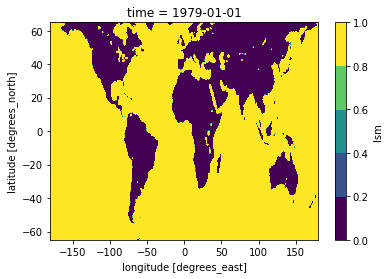

In [70]:
(lsm.lsm.squeeze() < 0.19).plot.contourf()
# np.isnan(ds.sst[0,:,:]).plot.contourf()

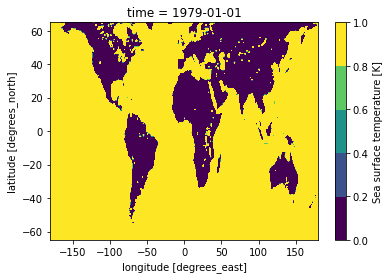

In [72]:
# (lsm.lsm.squeeze() < 0.01).plot.contourf()
(~np.isnan(ds.sst[0,:,:])).plot.contourf()

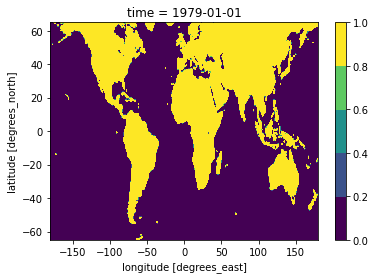

In [69]:
(((lsm.lsm.squeeze() < 0.19)*1 - np.isnan(ds.sst[0,:,:])*1) == -1).plot.contourf()

Text(0.5, 1.0, 'EOF1 expressed as correlation')

/opt/miniconda3/envs/py38/lib/python3.8/site-packages/cartopy/mpl/style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


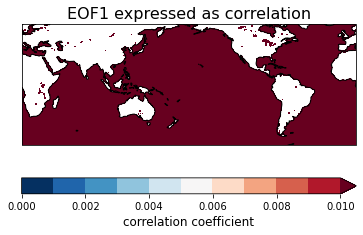

In [73]:
# Plot the leading EOF expressed as correlation in the Pacific domain.
clevs = np.linspace(0, 0.01, 11)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=190))
fill = ds.sst[0,:,:].plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())
# fill = (ds.tp[0,:,:] * ~(lsm.lsm.squeeze() > 0.19)).plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
#                              add_colorbar=False, transform=ccrs.PlateCarree())

ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
cb = plt.colorbar(fill, orientation='horizontal')
cb.set_label('correlation coefficient', fontsize=12)
# ax.set_extent([120,300,65,-65])
ax.set_title('EOF1 expressed as correlation', fontsize=16)


### Part 2
